In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/mgr

/content/drive/MyDrive/mgr


In [ ]:
import os
import torch
from torchvision import datasets, transforms
from PIL import Image

device = 'cuda'
masks = []
raw_imgs = []
for filename in os.listdir("test/raw"):
    mask = Image.open(f"test/mask/maska_{filename.split('.')[0].split('_')[1]}.png")
    raw_img = Image.open(f"test/raw/{filename}")
    raw_img = transforms.Grayscale()(raw_img)
    mask = transforms.functional.pil_to_tensor(mask)
    mask = mask > 0
    masks.append(mask)
    raw_imgs.append(transforms.functional.pil_to_tensor(raw_img)/255)

X_test = raw_imgs.copy()
y_test = masks.copy()

X_test = torch.stack(X_test)
y_test = torch.stack(y_test)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [ ]:
import os
import torch
from torchvision import datasets, transforms
from PIL import Image

device = 'cuda'
masks = []
raw_imgs = []
resize = transforms.Resize((128,160))
for filename in os.listdir("test_2/raw"):
    mask = Image.open(f"test_2/mask/{filename.split('.')[0]}_maska.png")
    raw_img = Image.open(f"test_2/raw/{filename}")
    raw_img = transforms.Grayscale()(raw_img)
    raw_img = resize(raw_img)
    mask = resize(mask)
    mask = transforms.Grayscale()(mask)
    mask = transforms.functional.pil_to_tensor(mask)
    mask = mask > 0
    masks.append(mask)
    raw_imgs.append(transforms.functional.pil_to_tensor(raw_img)/255)

X_test_sp = raw_imgs.copy()
y_test_sp = masks.copy()

X_test_sp = torch.stack(X_test_sp)
y_test_sp = torch.stack(y_test_sp)
X_test_sp = X_test_sp.to(device)
y_test_sp = y_test_sp.to(device)

In [ ]:
X_test_vis = X_test_sp[[0, 10, 50, 100, 250]]
y_test_vis = y_test_sp[[0, 10, 50, 100, 250]]

In [ ]:
import torch
import torch.nn as nn

def get_pred_mask(pred, threshold=0.5):
        return (pred >= threshold)

def dice_coef(gt, pred):
    overlap = torch.sum(pred*gt)
    total_area = torch.sum(pred) + torch.sum(gt) + 0.0000001
    return torch.round(torch.mean((2*overlap)/total_area), decimals=5)

def iou_coef(gt, pred):
    overlap = (torch.sum(pred*gt))
    union = torch.sum(pred) + torch.sum(gt) - overlap + 0.0000001
    return torch.round(torch.mean(overlap/union), decimals=5)


def loss_fun(pred, gt):
    bce = nn.BCELoss()
    return bce(pred, gt) + (1-dice_coef(gt, get_pred_mask(pred)))

def eval_model(model, test, batch_size):
  val_x, val_y = test
  with torch.no_grad():
    model.eval()
    all_losses = []
    all_dices = []
    all_ious = []
    for i in range(0, len(val_x), batch_size):
        x = val_x[i:i+batch_size]
        y = val_y[i:i+batch_size]
        #x, y = torch.stack(x).type(torch.float), torch.stack(y).type(torch.float)
        x, y = x.type(torch.float), y.type(torch.float)
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fun(pred, y)
        all_losses.append(loss)
        pred = get_pred_mask(pred)
        all_dices.append(dice_coef(y, pred))
        all_ious.append(iou_coef(y, pred))
    pred.detach().cpu().min()
    all_losses = torch.Tensor(all_losses)
    all_dices = torch.Tensor(all_dices)
    all_ious = torch.Tensor(all_ious)
    return torch.mean(all_dices), torch.mean(all_ious), torch.mean(all_losses)

## UNet

Bez crop

In [ ]:
y_test.shape

torch.Size([311, 1, 128, 160])

In [ ]:
y_test_sp.shape

torch.Size([256, 3, 128, 160])

In [ ]:
import matplotlib.pyplot as plt

def visualise_state(model, plot_val, plot=True):
  X_val, y_val = plot_val
  all_dices = []
  all_ious = []
  with torch.no_grad():
      model.eval()
      for i in range(0, len(X_val)):
          x = X_val[i]
          y = y_val[i]
          x, y = x.type(torch.float), y.type(torch.float)
          x, y = x.to(device), y.to(device)
          x = x.unsqueeze(0)
          y = y.unsqueeze(0)
          pred = model(x)
          pred = get_pred_mask(pred)
          all_dices.append(dice_coef(y, pred))
          all_ious.append(iou_coef(y, pred))
          if plot:
              fig, axs = plt.subplots(1, 2)

              axs[0].imshow(x[0].permute(1,2,0).detach().cpu(), cmap='gray')
              mask_rgb = y[0].detach().cpu().repeat((3, 1, 1)).permute((1,2,0))
              mask_rgb_2 = torch.zeros(mask_rgb.shape, dtype=torch.int32)
              mask_rgb_2[torch.all(mask_rgb == True, dim=2)] = torch.tensor([255, 0, 0], dtype=torch.int32)
              axs[1].imshow(mask_rgb_2)
              axs[1].imshow(pred[0].permute(1,2,0).detach().cpu(), cmap='gray', alpha=0.7)

              plt.show()
  dice, iou = torch.mean(torch.stack(all_dices)), torch.mean(torch.stack(all_ious))
  print(f"------\n10 val pics results IOU: {iou}, Dice: {dice}\n------")

In [ ]:
from UNet import UNet

model = UNet()
model.load_state_dict(torch.load('state_dict/model_state_14_bez_crop.pth')['state_dict'])
model = model.to('cuda')
dice, iou, loss = eval_model(model, (X_test, y_test), 20)
print(f"Wyniki dla sub zbioru: \nDice: {dice}, IoU: {iou}, Loss: {loss}")
dice, iou, loss = eval_model(model, (X_test_sp, y_test_sp), 20)
print(f"Wyniki dla specjalnego zbioru: \nDice: {dice}, IoU: {iou}, Loss: {loss}")

Wyniki dla sub zbioru: 
Dice: 0.9473249912261963, IoU: 0.8999806642532349, Loss: 0.06359609216451645
Wyniki dla specjalnego zbioru: 
Dice: 0.6528208255767822, IoU: 0.4876599907875061, Loss: 0.3731823265552521


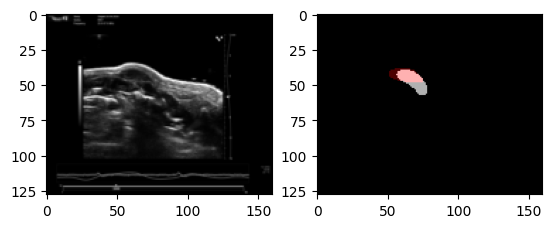

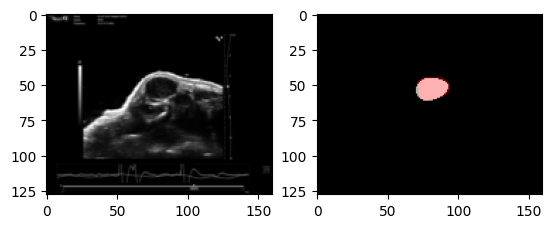

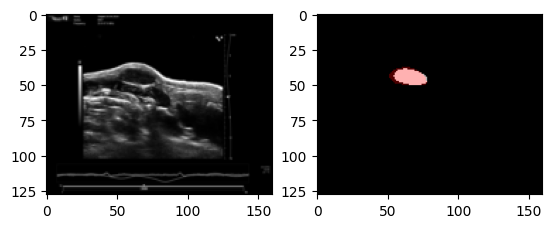

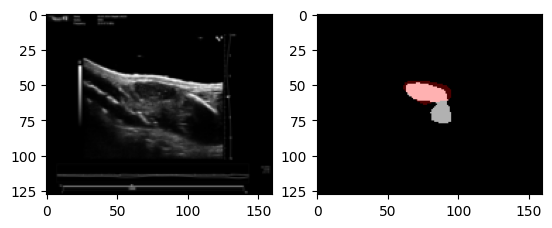

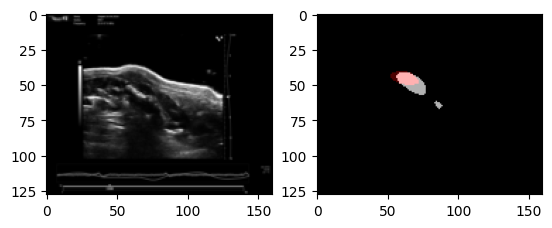

------
10 val pics results IOU: 0.5846900343894958, Dice: 0.7257160544395447
------


In [ ]:
visualise_state(model, (X_test_vis, y_test_vis))

Crop

In [ ]:
model = UNet()
model.load_state_dict(torch.load('state_dict/model_state_14_crop.pth')['state_dict'])
model = model.to('cuda')
dice, iou, loss = eval_model(model, (X_test, y_test), 20)
print(f"Wyniki dla sub zbioru: \nDice: {dice}, IoU: {iou}, Loss: {loss}")
dice, iou, loss = eval_model(model, (X_test_sp, y_test_sp), 20)
print(f"Wyniki dla specjalnego zbioru: \nDice: {dice}, IoU: {iou}, Loss: {loss}")

Wyniki dla sub zbioru: 
Dice: 0.9273162484169006, IoU: 0.8645581007003784, Loss: 0.08861177414655685
Wyniki dla specjalnego zbioru: 
Dice: 0.4755115807056427, IoU: 0.3132953643798828, Loss: 0.5636523365974426


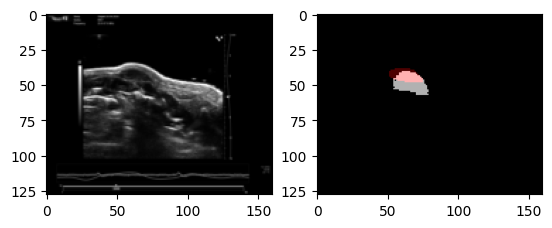

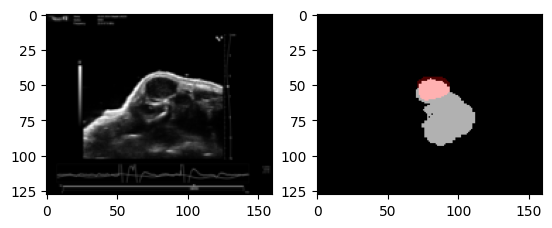

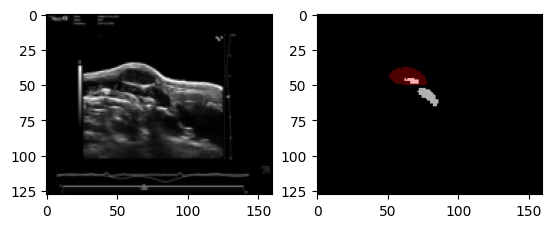

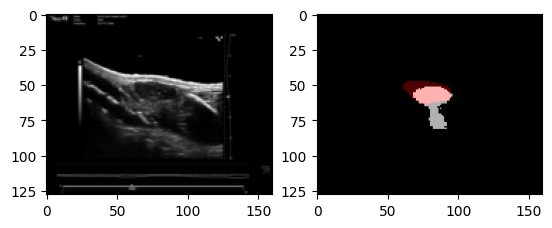

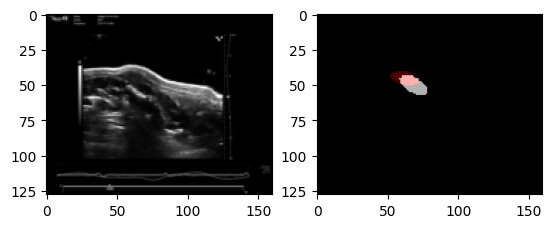

------
10 val pics results IOU: 0.2617020010948181, Dice: 0.4004039764404297
------


In [ ]:
visualise_state(model, (X_test_vis, y_test_vis))

## ResUNet

### Wczytanie

In [ ]:
import torch.nn as nn
import torch


class ResidualConv(nn.Module):
    def __init__(self, input_dim, output_dim, stride, padding):
        super(ResidualConv, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(input_dim),
            nn.ReLU(),
            nn.Conv2d(
                input_dim, output_dim, kernel_size=3, stride=stride, padding=padding
            ),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(output_dim),
        )

    def forward(self, x):

        return self.conv_block(x) + self.conv_skip(x)


class Upsample(nn.Module):
    def __init__(self, input_dim, output_dim, kernel, stride):
        super(Upsample, self).__init__()

        self.upsample = nn.ConvTranspose2d(
            input_dim, output_dim, kernel_size=kernel, stride=stride
        )

    def forward(self, x):
        return self.upsample(x)


class Squeeze_Excite_Block(nn.Module):
    def __init__(self, channel, reduction=16):
        super(Squeeze_Excite_Block, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class ASPP(nn.Module):
    def __init__(self, in_dims, out_dims, rate=[6, 12, 18]):
        super(ASPP, self).__init__()

        self.aspp_block1 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[0], dilation=rate[0]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )
        self.aspp_block2 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[1], dilation=rate[1]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )
        self.aspp_block3 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[2], dilation=rate[2]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )

        self.output = nn.Conv2d(len(rate) * out_dims, out_dims, 1)
        self._init_weights()

    def forward(self, x):
        x1 = self.aspp_block1(x)
        x2 = self.aspp_block2(x)
        x3 = self.aspp_block3(x)
        out = torch.cat([x1, x2, x3], dim=1)
        return self.output(out)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


class Upsample_(nn.Module):
    def __init__(self, scale=2):
        super(Upsample_, self).__init__()

        self.upsample = nn.Upsample(mode="bilinear", scale_factor=scale)

    def forward(self, x):
        return self.upsample(x)


class AttentionBlock(nn.Module):
    def __init__(self, input_encoder, input_decoder, output_dim):
        super(AttentionBlock, self).__init__()

        self.conv_encoder = nn.Sequential(
            nn.BatchNorm2d(input_encoder),
            nn.ReLU(),
            nn.Conv2d(input_encoder, output_dim, 3, padding=1),
            nn.MaxPool2d(2, 2),
        )

        self.conv_decoder = nn.Sequential(
            nn.BatchNorm2d(input_decoder),
            nn.ReLU(),
            nn.Conv2d(input_decoder, output_dim, 3, padding=1),
        )

        self.conv_attn = nn.Sequential(
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, 1, 1),
        )

    def forward(self, x1, x2):
        out = self.conv_encoder(x1) + self.conv_decoder(x2)
        out = self.conv_attn(out)
        return out * x2

In [ ]:
import torch
import torch.nn as nn



class ResUnet(nn.Module):
    def __init__(self, channel, filters=[64, 128, 256, 512]):
        super(ResUnet, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(),
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
        )
        self.input_skip = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1)
        )

        self.residual_conv_1 = ResidualConv(filters[0], filters[1], 2, 1)
        self.residual_conv_2 = ResidualConv(filters[1], filters[2], 2, 1)

        self.bridge = ResidualConv(filters[2], filters[3], 2, 1)

        self.upsample_1 = Upsample(filters[3], filters[3], 2, 2)
        self.up_residual_conv1 = ResidualConv(filters[3] + filters[2], filters[2], 1, 1)

        self.upsample_2 = Upsample(filters[2], filters[2], 2, 2)
        self.up_residual_conv2 = ResidualConv(filters[2] + filters[1], filters[1], 1, 1)

        self.upsample_3 = Upsample(filters[1], filters[1], 2, 2)
        self.up_residual_conv3 = ResidualConv(filters[1] + filters[0], filters[0], 1, 1)

        self.output_layer = nn.Sequential(
            nn.Conv2d(filters[0], 1, 1, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Encode
        x1 = self.input_layer(x) + self.input_skip(x)
        x2 = self.residual_conv_1(x1)
        x3 = self.residual_conv_2(x2)
        # Bridge
        x4 = self.bridge(x3)
        # Decode
        x4 = self.upsample_1(x4)
        x5 = torch.cat([x4, x3], dim=1)

        x6 = self.up_residual_conv1(x5)

        x6 = self.upsample_2(x6)
        x7 = torch.cat([x6, x2], dim=1)

        x8 = self.up_residual_conv2(x7)

        x8 = self.upsample_3(x8)
        x9 = torch.cat([x8, x1], dim=1)

        x10 = self.up_residual_conv3(x9)

        output = self.output_layer(x10)

        return output

### Bez crop

In [ ]:
model = ResUnet(1)
model.load_state_dict(torch.load('state_dict/model_state_14_bez_crop_resunet.pth')['state_dict'])
model = model.to('cuda')
dice, iou, loss = eval_model(model, (X_test, y_test), 20)
print(f"Wyniki dla sub zbioru: \nDice: {dice}, IoU: {iou}, Loss: {loss}")
dice, iou, loss = eval_model(model, (X_test_sp, y_test_sp), 20)
print(f"Wyniki dla specjalnego zbioru: \nDice: {dice}, IoU: {iou}, Loss: {loss}")

Wyniki dla sub zbioru: 
Dice: 0.929185688495636, IoU: 0.8678368926048279, Loss: 0.08595655858516693
Wyniki dla specjalnego zbioru: 
Dice: 0.7304239273071289, IoU: 0.5778123140335083, Loss: 0.2862147092819214


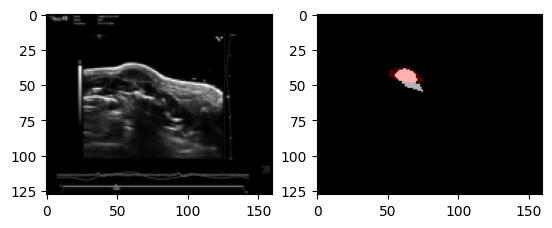

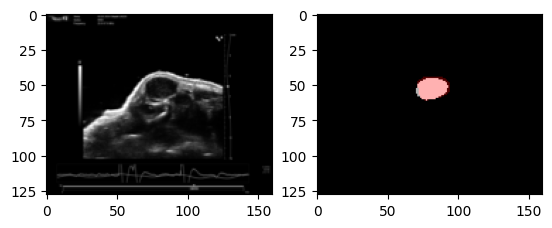

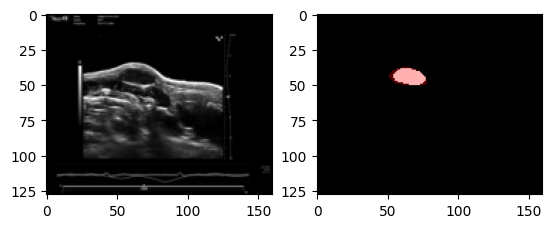

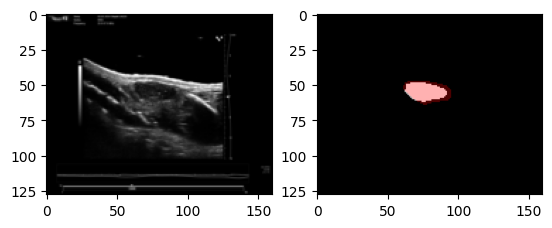

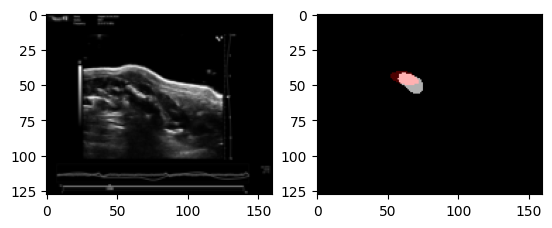

------
10 val pics results IOU: 0.6360200047492981, Dice: 0.7663519978523254
------


In [ ]:
visualise_state(model, (X_test_vis, y_test_vis))

### Pretrain

In [ ]:
model = ResUnet(1)
model.load_state_dict(torch.load('state_dict/model_state_9_bez_crop_resunet_pre.pth')['state_dict'])
model = model.to('cuda')
dice, iou, loss = eval_model(model, (X_test, y_test), 20)
print(f"Wyniki dla sub zbioru: \nDice: {dice}, IoU: {iou}, Loss: {loss}")
dice, iou, loss = eval_model(model, (X_test_sp, y_test_sp), 20)
print(f"Wyniki dla specjalnego zbioru: \nDice: {dice}, IoU: {iou}, Loss: {loss}")

Wyniki dla sub zbioru: 
Dice: 0.9235575199127197, IoU: 0.8581262230873108, Loss: 0.09256672859191895
Wyniki dla specjalnego zbioru: 
Dice: 0.7505092620849609, IoU: 0.6038638353347778, Loss: 0.264003723859787


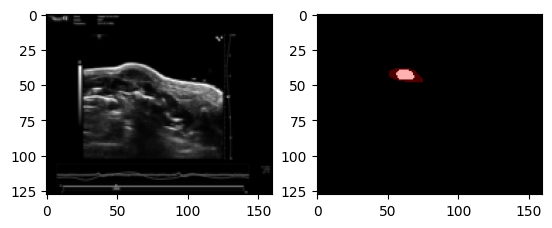

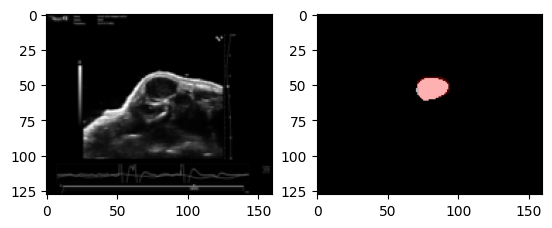

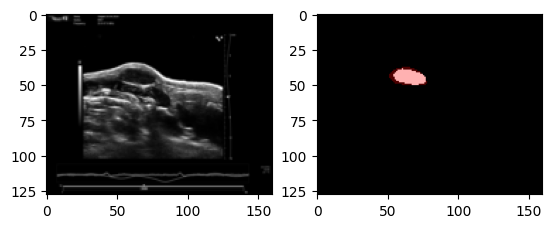

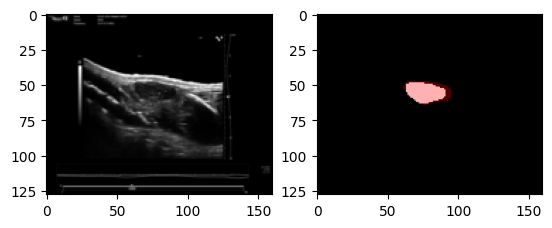

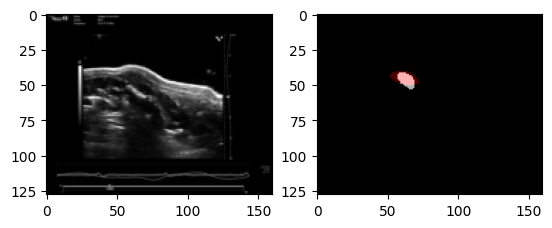

------
10 val pics results IOU: 0.636616051197052, Dice: 0.7668520212173462
------


In [ ]:
visualise_state(model, (X_test_vis, y_test_vis))

### Crop

In [ ]:
model = ResUnet(1)
model.load_state_dict(torch.load('state_dict/model_state_14_crop_resunet.pth')['state_dict'])
model = model.to('cuda')
dice, iou, loss = eval_model(model, (X_test, y_test), 20)
print(f"Wyniki dla sub zbioru: \nDice: {dice}, IoU: {iou}, Loss: {loss}")
dice, iou, loss = eval_model(model, (X_test_sp, y_test_sp), 20)
print(f"Wyniki dla specjalnego zbioru: \nDice: {dice}, IoU: {iou}, Loss: {loss}")

Wyniki dla sub zbioru: 
Dice: 0.9074187278747559, IoU: 0.8309199810028076, Loss: 0.11316253989934921
Wyniki dla specjalnego zbioru: 
Dice: 0.6134584546089172, IoU: 0.4452892541885376, Loss: 0.4153330624103546


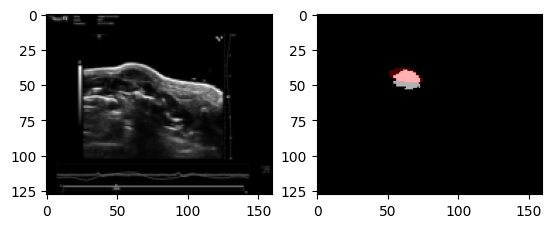

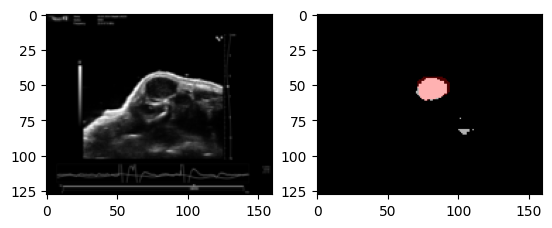

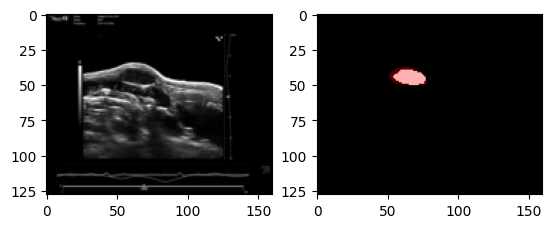

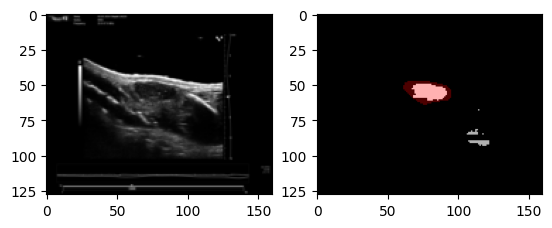

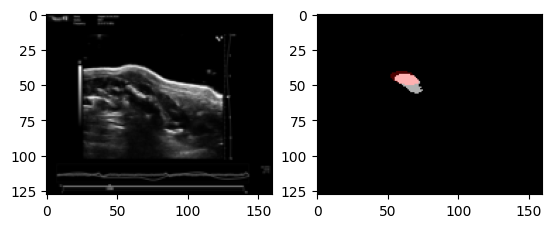

------
10 val pics results IOU: 0.5702460408210754, Dice: 0.7193320393562317
------


In [ ]:
visualise_state(model, (X_test_vis, y_test_vis))

# Attention

## Wczytywanie

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)

            x1 = self.conv(x+x1)
        return x1

class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1


class single_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(single_conv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x

class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi


class AttU_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(AttU_Net,self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)

        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)

        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return nn.Sigmoid()(d1)

## Bez crop

In [ ]:
model = AttU_Net(1)
model.load_state_dict(torch.load('state_dict/model_state_14_bez_crop_attunet.pth')['state_dict'])
model = model.to('cuda')
dice, iou, loss = eval_model(model, (X_test, y_test), 20)
print(f"Wyniki dla sub zbioru: \nDice: {dice}, IoU: {iou}, Loss: {loss}")
dice, iou, loss = eval_model(model, (X_test_sp, y_test_sp), 20)
print(f"Wyniki dla specjalnego zbioru: \nDice: {dice}, IoU: {iou}, Loss: {loss}")

Wyniki dla sub zbioru: 
Dice: 0.9353750348091125, IoU: 0.8786925673484802, Loss: 0.07785163819789886
Wyniki dla specjalnego zbioru: 
Dice: 0.6565861105918884, IoU: 0.49143773317337036, Loss: 0.3699650168418884


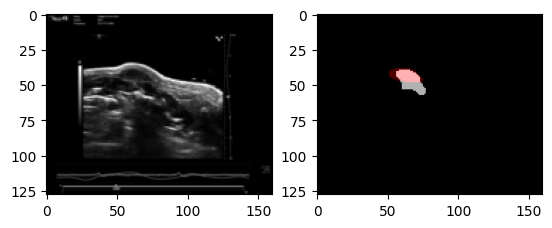

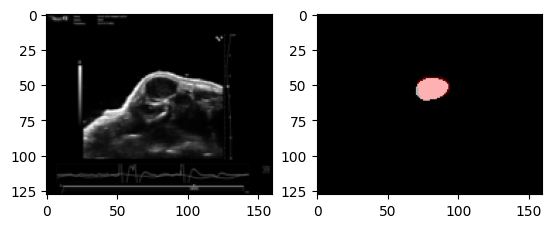

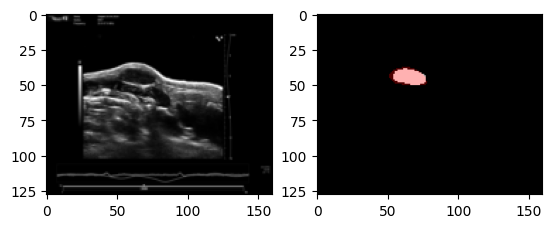

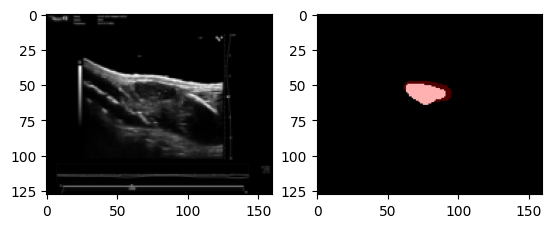

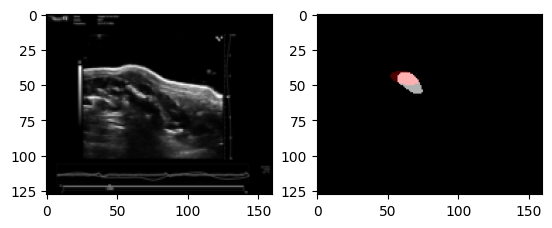

------
10 val pics results IOU: 0.6301720142364502, Dice: 0.7625500559806824
------


In [ ]:
visualise_state(model, (X_test_vis, y_test_vis))

pretrain:

In [ ]:
model = AttU_Net(1)
model.load_state_dict(torch.load('state_dict/model_state_9_bez_crop_attunet_pretrain.pth')['state_dict'])
model = model.to('cuda')
dice, iou, loss = eval_model(model, (X_test, y_test), 20)
print(f"Wyniki dla sub zbioru: \nDice: {dice}, IoU: {iou}, Loss: {loss}")
dice, iou, loss = eval_model(model, (X_test_sp, y_test_sp), 20)
print(f"Wyniki dla specjalnego zbioru: \nDice: {dice}, IoU: {iou}, Loss: {loss}")

Wyniki dla sub zbioru: 
Dice: 0.9230474829673767, IoU: 0.8573031425476074, Loss: 0.09383495151996613
Wyniki dla specjalnego zbioru: 
Dice: 0.7310577034950256, IoU: 0.5780176520347595, Loss: 0.28690779209136963


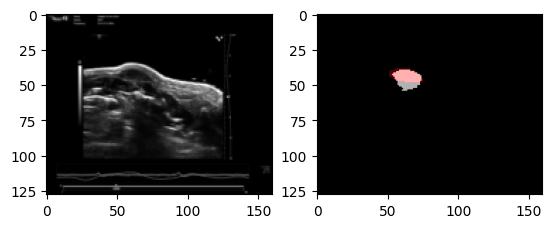

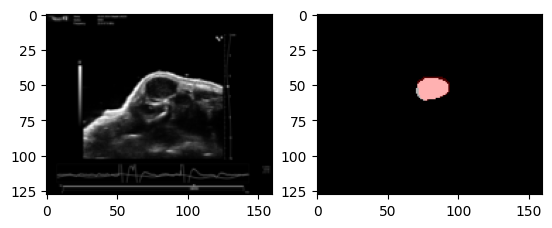

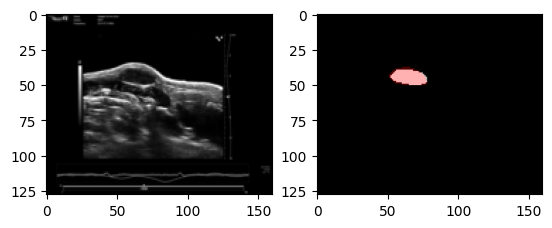

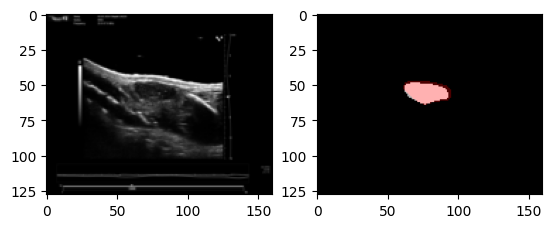

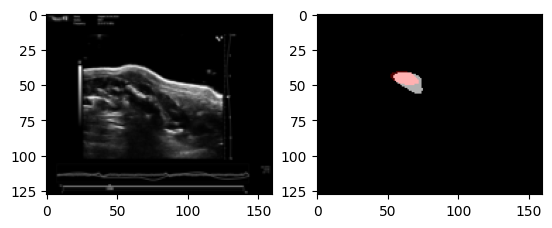

------
10 val pics results IOU: 0.6957300305366516, Dice: 0.8138440251350403
------


In [ ]:
visualise_state(model, (X_test_vis, y_test_vis))

## Crop

In [ ]:
model = AttU_Net(1)
model.load_state_dict(torch.load('state_dict/model_state_14_crop_attunet.pth')['state_dict'])
model = model.to('cuda')
dice, iou, loss = eval_model(model, (X_test, y_test), 20)
print(f"Wyniki dla sub zbioru: \nDice: {dice}, IoU: {iou}, Loss: {loss}")
dice, iou, loss = eval_model(model, (X_test_sp, y_test_sp), 20)
print(f"Wyniki dla specjalnego zbioru: \nDice: {dice}, IoU: {iou}, Loss: {loss}")

Wyniki dla sub zbioru: 
Dice: 0.9412887692451477, IoU: 0.8891637921333313, Loss: 0.07143612205982208
Wyniki dla specjalnego zbioru: 
Dice: 0.6781800389289856, IoU: 0.5158253908157349, Loss: 0.34084802865982056


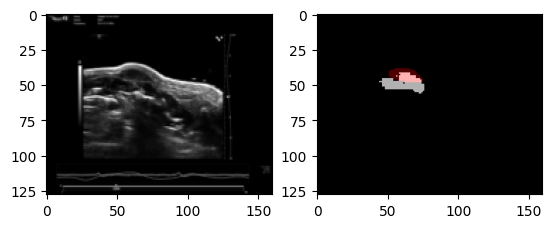

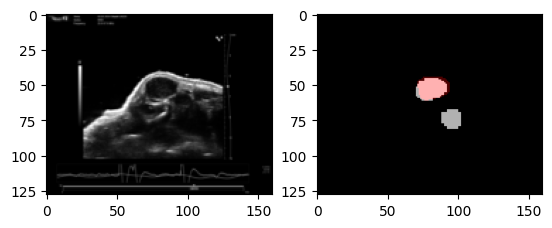

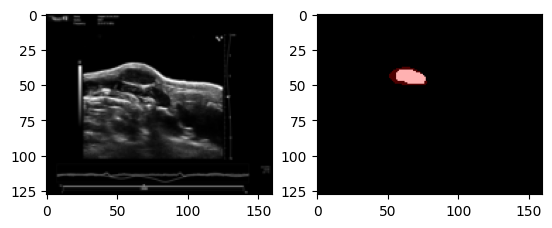

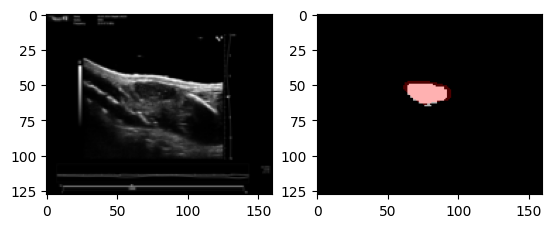

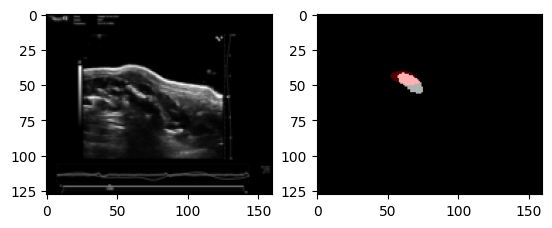

------
10 val pics results IOU: 0.5036880373954773, Dice: 0.6512700319290161
------


In [ ]:
visualise_state(model, (X_test_vis, y_test_vis))

## R2AttUNet

## Wczytywanie

In [ ]:
from torch import nn

class R2AttU_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1,t=2):
        super(R2AttU_Net,self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)

        self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)

        self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)

        self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)


        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)

        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)

        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_RRCNN5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)

        return nn.Sigmoid()(d1)

## Bez crop

In [ ]:
model = R2AttU_Net(1)
model.load_state_dict(torch.load('state_dict/model_state_14_bez_crop_r2attunet.pth')['state_dict'])
model = model.to('cuda')
dice, iou, loss = eval_model(model, (X_test, y_test), 20)
print(f"Wyniki dla sub zbioru: \nDice: {dice}, IoU: {iou}, Loss: {loss}")
dice, iou, loss = eval_model(model, (X_test_sp, y_test_sp), 20)
print(f"Wyniki dla specjalnego zbioru: \nDice: {dice}, IoU: {iou}, Loss: {loss}")

Wyniki dla sub zbioru: 
Dice: 0.946158766746521, IoU: 0.8978831171989441, Loss: 0.0648728683590889
Wyniki dla specjalnego zbioru: 
Dice: 0.7159091234207153, IoU: 0.558405339717865, Loss: 0.30331382155418396


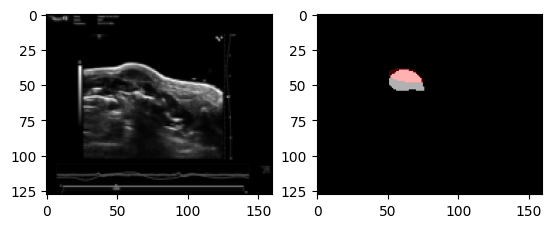

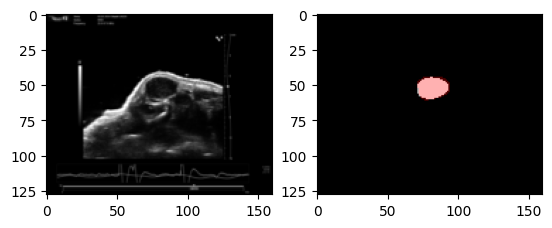

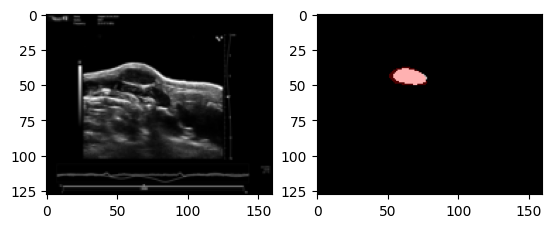

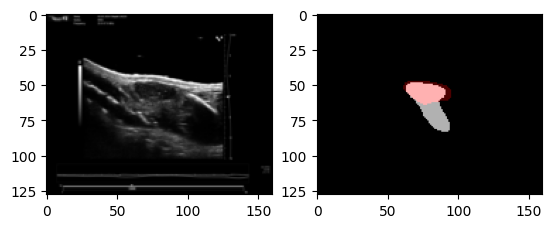

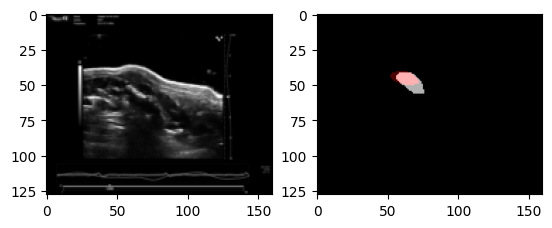

------
10 val pics results IOU: 0.5825420618057251, Dice: 0.7237839698791504
------


In [ ]:
visualise_state(model, (X_test_vis, y_test_vis))

pretrain

In [ ]:
model = R2AttU_Net(1)
model.load_state_dict(torch.load('state_dict/model_state_9_bez_crop_r2a_pre.pth')['state_dict'])
model = model.to('cuda')
dice, iou, loss = eval_model(model, (X_test, y_test), 20)
print(f"Wyniki dla sub zbioru: \nDice: {dice}, IoU: {iou}, Loss: {loss}")
dice, iou, loss = eval_model(model, (X_test_sp, y_test_sp), 20)
print(f"Wyniki dla specjalnego zbioru: \nDice: {dice}, IoU: {iou}, Loss: {loss}")

Wyniki dla sub zbioru: 
Dice: 0.9256212711334229, IoU: 0.8617718815803528, Loss: 0.08960002660751343
Wyniki dla specjalnego zbioru: 
Dice: 0.6953822374343872, IoU: 0.5351091623306274, Loss: 0.32277825474739075


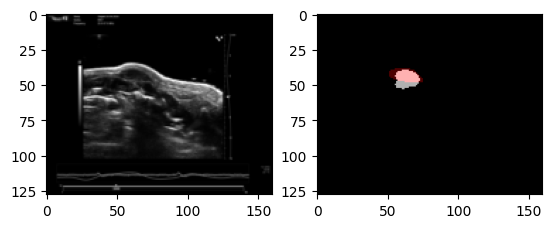

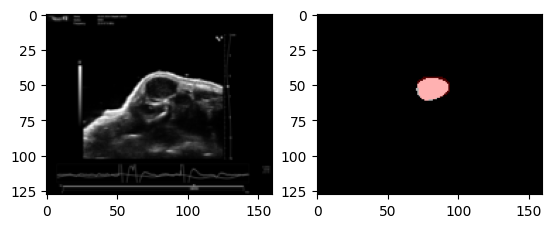

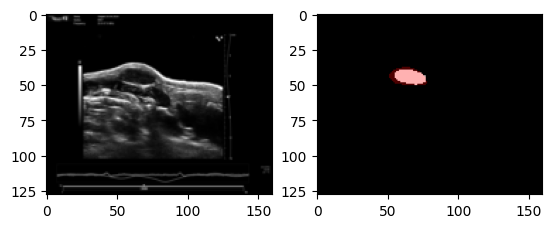

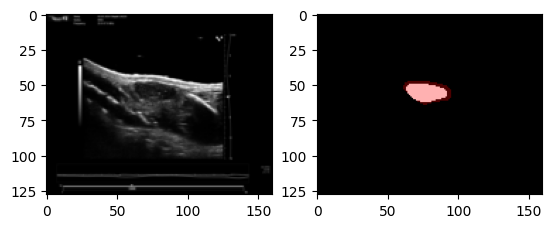

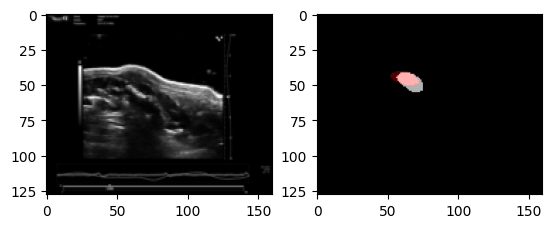

------
10 val pics results IOU: 0.629516065120697, Dice: 0.7650740146636963
------


In [ ]:
visualise_state(model, (X_test_vis, y_test_vis))

## Crop

In [ ]:
model = R2AttU_Net(1)
model.load_state_dict(torch.load('state_dict/model_state_14_crop_r2a.pth')['state_dict'])
model = model.to('cuda')
dice, iou, loss = eval_model(model, (X_test, y_test), 20)
print(f"Wyniki dla sub zbioru: \nDice: {dice}, IoU: {iou}, Loss: {loss}")
dice, iou, loss = eval_model(model, (X_test_sp, y_test_sp), 20)
print(f"Wyniki dla specjalnego zbioru: \nDice: {dice}, IoU: {iou}, Loss: {loss}")

Wyniki dla sub zbioru: 
Dice: 0.9310281872749329, IoU: 0.87107253074646, Loss: 0.08344423770904541
Wyniki dla specjalnego zbioru: 
Dice: 0.652559220790863, IoU: 0.48666155338287354, Loss: 0.3682071268558502


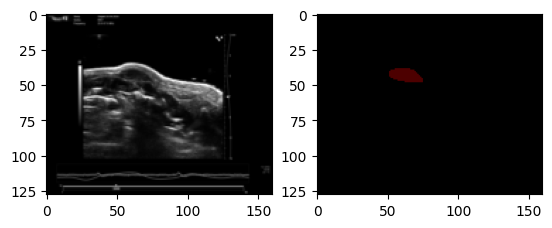

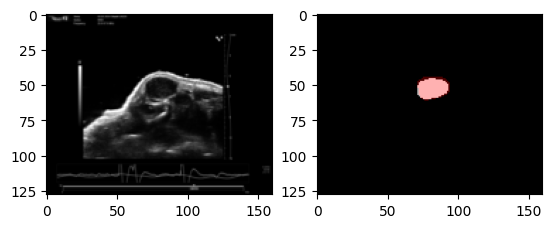

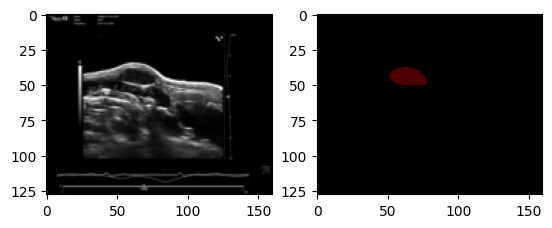

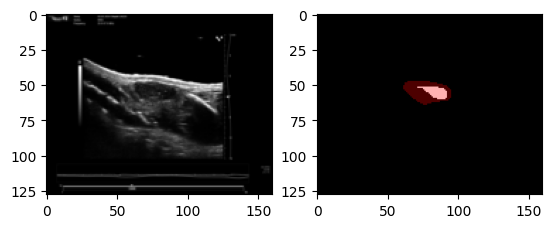

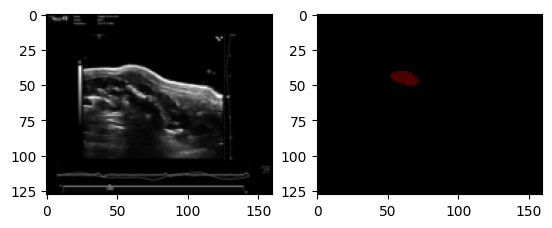

------
10 val pics results IOU: 0.2111000120639801, Dice: 0.2605220079421997
------


In [ ]:
visualise_state(model, (X_test_vis, y_test_vis))